In [1]:
import sys, os
sys.path.append('..')
import bioGRID as bg
import STRING
import IntAct
import random as rn
import onPPILinkPred as ppiLPred
import numpy as np
import json
from itertools import combinations
from matplotlib import pyplot as plt
from statistics import mean
from statistics import median
import traversalHelper as tr
import pandas as pd
from collections import defaultdict
import matplotlib.gridspec as gridspec
import math
from matplotlib.ticker import NullFormatter
import domain as dm
from scipy.signal import savgol_filter
import MINT
from matplotlib_venn import venn2

# Data Generating

data to generate: sampled PPI dataset (bioGRID & STRING & InAct (spoke mode), MINT), 50% sampled, 10 samples

In [3]:
# DataFrame standard: {nodeA, nodeB, type, score}
bioGRID_GGI, bioGRID_PPI = bioGRID.parse_bioGRID(root="../")

sampleFName, sampleBase = ['bioGRID'], [bioGRID_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

C:\Users\andy8\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\andy8\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# DataFrame standard: {nodeA, nodeB, type, score}
MINT_GGI, MINT_PPI = MINT.parse_MINT(root="../")

sampleFName, sampleBase = ['MINT'], [MINT_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [16]:
# DataFrame standard: {nodeA, nodeB, type, score}
IntAct_GGI, IntAct_PPI = IntAct.parse_IntAct(root="../", spokeModel=True)

sampleFName, sampleBase = ['IntAct_spoke'], [IntAct_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [15]:
# DataFrame standard: {nodeA, nodeB, type, score}
STRING_GGI, STRING_PPI = STRING.parse_STRING(root="../")

sampleFName, sampleBase = ['STRING'], [STRING_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

# Data Crunching

see dataGen.py, since running in jupyter notebook may have errors

# Read Data

In [2]:
predPPIs = {}
with open('./resultData/trimmed_predPPIs.json', 'r') as f:
    for line in f.readlines(): predPPIs.update(json.loads(line))
print(list(predPPIs.keys()))

['uvSpec_xySpec_xyContrib_tenTrial_bioGRID', 'xyContrib_dualCN_tenTrial_bioGRID', 'commonNeighbor_tenTrial_bioGRID', 'L3Normalizing_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_tenTrial_STRING', 'xyContrib_dualCN_tenTrial_STRING', 'commonNeighbor_tenTrial_STRING', 'L3Normalizing_tenTrial_STRING', 'L3_tenTrial_bioGRID', 'L3_tenTrial_STRING', 'L3uvJoin_tenTrial_bioGRID', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_bioGRID', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'commonNeighbor_tenTrial_IntAct', 'L3uvJoin_tenTrial_IntAct', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_IntAct', 'commonNeighbor_tenTrial_MINT', 'L3uvJoin_tenTrial_MINT', 'xyContrib_dualCN_uvJoin_tenTrial_MINT', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_MINT', 'commonNeighbor_tenTrial_IntAct_spoke', 'L3uvJoin_tenTrial_IntAct_spoke', 'xyContrib_dualCN_uvJoin_tenTrial_Int

In [14]:
# samplePPI
bg_samplePPIs, STRING_samplePPIs, MINT_samplePPIs, IntAct_samplePPIs, IntAct_spoke_samplePPIs = [], [], [], [], []
with open('./genData/bioGRID_sampledPPIs.json', 'r') as f:
    bg_samplePPIs = json.loads(f.read())
with open('./genData/STRING_sampledPPIs.json', 'r') as f:
    STRING_samplePPIs = json.loads(f.read())
with open('./genData/IntAct_spoke_sampledPPIs.json', 'r') as f:
    IntAct_spoke_samplePPIs = json.loads(f.read())
with open('./genData/MINT_sampledPPIs.json', 'r') as f:
    MINT_samplePPIs = json.loads(f.read())
bg_samplePPIr, STRING_samplePPIr, IntAct_samplePPIr, IntAct_spoke_samplePPIr, MINT_samplePPIr = [], [], [], [], []
for ppis in bg_samplePPIs: bg_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in STRING_samplePPIs: STRING_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in MINT_samplePPIs: MINT_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in IntAct_spoke_samplePPIs: IntAct_spoke_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
print(bg_samplePPIs[0][0:5], len(bg_samplePPIs))
print(STRING_samplePPIs[0][0:5], len(STRING_samplePPIs))

[['SSB2', 'NAT1'], ['TFB1', 'APE1'], ['MMS22', 'MMS1'], ['NOP14', 'RPS11A'], ['VPS29', 'PEP8']] 10
[['NOP58', 'RPS0A'], ['BDF1', 'SNT2'], ['SFH1', 'UAF30'], ['RPS3', 'SLX9'], ['HSC82', 'SCP160']] 10


In [5]:
precRecMap = {}
with open('./resultData/PRCurveMap.json', 'r') as f: precRecMap = json.loads(f.read())
print(list(precRecMap.keys()))

['commonNeighbor_tenTrial_bioGRID_0', 'commonNeighbor_tenTrial_bioGRID_1', 'commonNeighbor_tenTrial_bioGRID_2', 'commonNeighbor_tenTrial_bioGRID_3', 'commonNeighbor_tenTrial_bioGRID_4', 'commonNeighbor_tenTrial_bioGRID_5', 'commonNeighbor_tenTrial_bioGRID_6', 'commonNeighbor_tenTrial_bioGRID_7', 'commonNeighbor_tenTrial_bioGRID_8', 'commonNeighbor_tenTrial_bioGRID_9', 'commonNeighbor_tenTrial_STRING_0', 'commonNeighbor_tenTrial_STRING_1', 'commonNeighbor_tenTrial_STRING_2', 'commonNeighbor_tenTrial_STRING_3', 'commonNeighbor_tenTrial_STRING_4', 'commonNeighbor_tenTrial_STRING_5', 'commonNeighbor_tenTrial_STRING_6', 'commonNeighbor_tenTrial_STRING_7', 'commonNeighbor_tenTrial_STRING_8', 'commonNeighbor_tenTrial_STRING_9', 'commonNeighbor_tenTrial_bioGRID_GGI_0', 'commonNeighbor_tenTrial_bioGRID_GGI_1', 'commonNeighbor_tenTrial_bioGRID_GGI_2', 'commonNeighbor_tenTrial_bioGRID_GGI_3', 'commonNeighbor_tenTrial_bioGRID_GGI_4', 'commonNeighbor_tenTrial_bioGRID_GGI_5', 'commonNeighbor_tenTria

In [6]:
GOScores, GOPPI = {}, {}
with open('./GOSemSimFinalizedData/GOScore.json', 'r') as f: GOScores = json.loads(f.read())
with open('./GOSemSimFinalizedData/GOPPI.json', 'r') as f: GOPPI = json.loads(f.read())
print(list(GOScores.keys()))

['commonNeighbor_tenTrial_bioGRID', 'L3Normalizing_tenTrial_bioGRID', 'xyContrib_dualCN_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_tenTrial_bioGRID', 'commonNeighbor_tenTrial_STRING', 'L3Normalizing_tenTrial_STRING', 'xyContrib_dualCN_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_tenTrial_STRING', 'L3uvJoin_tenTrial_bioGRID', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_bioGRID', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'commonNeighbor_tenTrial_MINT', 'L3uvJoin_tenTrial_MINT', 'xyContrib_dualCN_uvJoin_tenTrial_MINT', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_MINT', 'commonNeighbor_tenTrial_IntAct', 'L3uvJoin_tenTrial_IntAct', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_IntAct', 'commonNeighbor_tenTrial_IntAct_spoke', 'L3uvJoin_tenTrial_IntAct_spoke', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct_spoke', 'uvSpec_xySpec_xyContrib_uvJoin_t

In [34]:
# check data
predPPIsK = list(predPPIs.keys())[0]
GOScoresK = list(GOScores.keys())[0]
print(len(predPPIs[predPPIsK][0]), len(GOScores[GOScoresK][0]))

86224 86224


In [15]:
essGenes, essGenesFromPPI = [], []
with open('./../data/parsed/giaever_essentialGenes.json', 'r') as f: essGenes = json.loads(f.read())
print(len(essGenes), essGenes[0:5])
essGenes = set(essGenes)

1080 ['TFC3', 'EFB1', 'MAK16', 'PRP45', 'POP5']


# Data Properties

In [41]:
# dataset edges
bioGRID_GGI_df, bioGRID_PPI_df = bg.parse_bioGRID(root='../')
STRING_GGI_df, STRING_PPI_df = STRING.parse_STRING(root='../')
IntAct_GGI_df, IntAct_PPI_df = IntAct.parse_IntAct(root='../', spokeModel=True)
MINT_GGI_df, MINT_PPI_df = MINT.parse_MINT(root='../')
print('PPI size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(STRING_PPI_df.index), len(bioGRID_PPI_df.index), len(IntAct_PPI_df.index), len(MINT_PPI_df.index)))

print('non-PPI size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(STRING_GGI_df.index), len(bioGRID_GGI_df.index), len(IntAct_GGI_df.index), len(MINT_GGI_df.index)))

bioGRID_nodes = tr.Helper.binary_relation_to_node(bioGRID_PPI_df[['nodeA', 'nodeB']].values.tolist())
STRING_nodes = tr.Helper.binary_relation_to_node(STRING_PPI_df[['nodeA', 'nodeB']].values.tolist())
IntAct_nodes = tr.Helper.binary_relation_to_node(IntAct_PPI_df[['nodeA', 'nodeB']].values.tolist())
MINT_nodes = tr.Helper.binary_relation_to_node(MINT_PPI_df[['nodeA', 'nodeB']].values.tolist())
print('# of nodes, bioGRID: {}, STRING: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(bioGRID_nodes), len(STRING_nodes), len(IntAct_nodes), len(MINT_nodes)))

# average candidate edges
STRING_candidateSz, bioGRID_candidateSz, IntAct_candidateSz, MINT_candidateSz = [], [], [], []
for i in range(0, 10):
    with open('./resultData/commonNeighbor_tenTrial_STRING_{}_PPI.json'.format(i), 'r') as f:
        STRING_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_bioGRID_{}_PPI.json'.format(i), 'r') as f:
        bioGRID_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_IntAct_spoke_{}_PPI.json'.format(i), 'r') as f:
        IntAct_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_MINT_{}_PPI.json'.format(i), 'r') as f:
        MINT_candidateSz.append(len(json.loads(f.read())))
print("candidate size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}".format(
    mean(STRING_candidateSz), mean(bioGRID_candidateSz), mean(IntAct_candidateSz), mean(MINT_candidateSz)))    

# selected top edges
trimNum = {'bioGRID': int(len([*bg.parse_bioGRID(root='../')][1].index)*0.5)
        , 'STRING': int(len([*STRING.parse_STRING(root='../')][1].index)*0.5)
        , 'IntAct': int(len([*IntAct.parse_IntAct(root='../', spokeModel=True)][1].index)*0.5)
        , 'MINT': int(len([*MINT.parse_MINT(root='../')][1].index)*0.5)}
print("top n edges: bioGRID: {}, STRING: {}, IntAct_spoke: {}, MINT: {}".format(
  trimNum['bioGRID'], trimNum['STRING'], trimNum['IntAct'], trimNum['MINT']))

PPI size, STRING: 46298, bioGRID: 172448, IntAct_spoke: 143781, MINT: 39552
non-PPI size, STRING: 62525, bioGRID: 576462, IntAct_spoke: 42, MINT: 143
# of nodes, bioGRID: 6835, STRING: 4574, IntAct_spoke: 5418, MINT: 4056
candidate size, STRING: 8870602.6, bioGRID: 20115400, IntAct_spoke: 11666106.4, MINT: 6482314.3
top n edges: bioGRID: 86224, STRING: 23149, IntAct_spoke: 71890, MINT: 19776


In [42]:
# overlap evaluation
_, bioGRID_PPI_df = bg.parse_bioGRID(root='../')
_, STRING_PPI_df = STRING.parse_STRING(root='../')
_, IntAct_PPI_df = IntAct.parse_IntAct(root='../', spokeModel=True)
_, MINT_PPI_df = MINT.parse_MINT(root='../')

bioGRID_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in bioGRID_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
STRING_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in STRING_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
IntAct_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in IntAct_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
MINT_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in MINT_PPI_df[['nodeA', 'nodeB']].values.tolist()]))

datasets = {'bioGRID': bioGRID_PPIs, 'STRING': STRING_PPIs, 'IntAct_spoke': IntAct_PPIs, 'MINT': MINT_PPIs}
for comb in list(combinations(list(datasets.keys()), 2)):
    [datasetA, datasetB] = comb
    print("{} overlaps {}: {}, {}".format(datasetA, datasetB, len(datasets[datasetA]&datasets[datasetB])/len(datasets[datasetA]), len(datasets[datasetA]&datasets[datasetB])/len(datasets[datasetB])))

bioGRID overlaps STRING: 0.13158330068347046, 0.3264287874206229
bioGRID overlaps IntAct_spoke: 0.08013582342954159, 0.11398565890992854
bioGRID overlaps MINT: 0.1278568630011754, 0.8416437414030261
STRING overlaps IntAct_spoke: 0.12842887381744353, 0.07363741067779608
STRING overlaps MINT: 0.13255432200095035, 0.35173085740486015
IntAct_spoke overlaps MINT: 0.060348991293794195, 0.27928702430077945


In [31]:
# runTime
fName = './resultData/runTime.json'
runTimeD = {}
with open(fName, 'r') as f: runTimeD = json.loads(f.read())
    
tags = ["commonNeighbor", "L3uvJoin", "uvSpec_xySpec_xyContrib_uvJoin", "xyContrib_dualCN_uvJoin", "CRA"]
datasets = ["STRING", "bioGRID", "IntAct_spoke", "MINT"]
for dataset in datasets:
    for tag in tags:
        secs = []
        for i in range(0, 10):
            dName = "{}_tenTrial_{}_{}".format(tag, dataset, i)
            secs.append(runTimeD[dName])
        avgSec = mean(secs)
        print("algor {}, dataset {}, avg min {}m".format(tag, dataset, avgSec/60))
    print("\n")

algor commonNeighbor, dataset STRING, avg min 1.0923774727185567m
algor L3uvJoin, dataset STRING, avg min 1.3159012790520985m
algor uvSpec_xySpec_xyContrib_uvJoin, dataset STRING, avg min 1.651599910656611m
algor xyContrib_dualCN_uvJoin, dataset STRING, avg min 1.6307893848419188m
algor CRA, dataset STRING, avg min 1.1051768418153125m


algor commonNeighbor, dataset bioGRID, avg min 2.8095081051190696m
algor L3uvJoin, dataset bioGRID, avg min 7.997513512770335m
algor uvSpec_xySpec_xyContrib_uvJoin, dataset bioGRID, avg min 59.86444462299347m
algor xyContrib_dualCN_uvJoin, dataset bioGRID, avg min 60.94699289838473m
algor CRA, dataset bioGRID, avg min 2.675769392251968m


algor commonNeighbor, dataset IntAct_spoke, avg min 1.6504763710498809m
algor L3uvJoin, dataset IntAct_spoke, avg min 4.07246942559878m
algor uvSpec_xySpec_xyContrib_uvJoin, dataset IntAct_spoke, avg min 32.72326174537341m
algor xyContrib_dualCN_uvJoin, dataset IntAct_spoke, avg min 33.95190339763959m
algor CRA, datase

# Data Analysis

# Stats Significance

In [8]:
def precRecPlot_multiLine(precsList, recsList, decimalPt, xTtickInterval, yTickInterval, legends, figsize=(30,30), font=20):
    interval = 1/(10**decimalPt)
    decimalPt = str(decimalPt)
    tmp = []
    corrStr = "{0:."+decimalPt+"f}"
    for precs in precsList: tmp.append([float(corrStr.format(prec)) for prec in precs])
    precsList = tmp.copy()
    tmp = []
    for recs in recsList: tmp.append([float(corrStr.format(rec)) for rec in recs])
    recsList = tmp.copy()
    fig = plt.figure(figsize=figsize)
    plt.rc('font', size=font)
    
    maxRec, maxPrec = max(np.asarray(recsList).flatten()), max(np.asarray(precsList).flatten())
    xTicks, yTicks = [i*xTtickInterval for i in range(0, int((maxRec+xTtickInterval)/xTtickInterval))], [i*yTickInterval for i in range(0, int((maxPrec+yTickInterval)/yTickInterval))]
    plt.xticks(xTicks)
    plt.yticks(yTicks)
    
    for i in range(0, len(precsList)):
        plt.plot(recsList[i], precsList[i], label=legends[i])
    plt.legend()
    ax = plt.gca()
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid(axis='y')
    return fig
"precRecPlot function"

'precRecPlot function'

In [20]:
plt.close("all")
%matplotlib widget

In [51]:
plt.close("all")
%matplotlib inline

In [9]:
def manual_transpose(arrs):
    inverted = []
    print([len(arr) for arr in arrs])
    for i in range(len(arrs[0])):
        inverted.append([arr[i] for arr in arrs])
    return inverted

In [10]:
def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

In [11]:
def standardize_plots(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate())))
    return alignedPrecsList, baseRecs

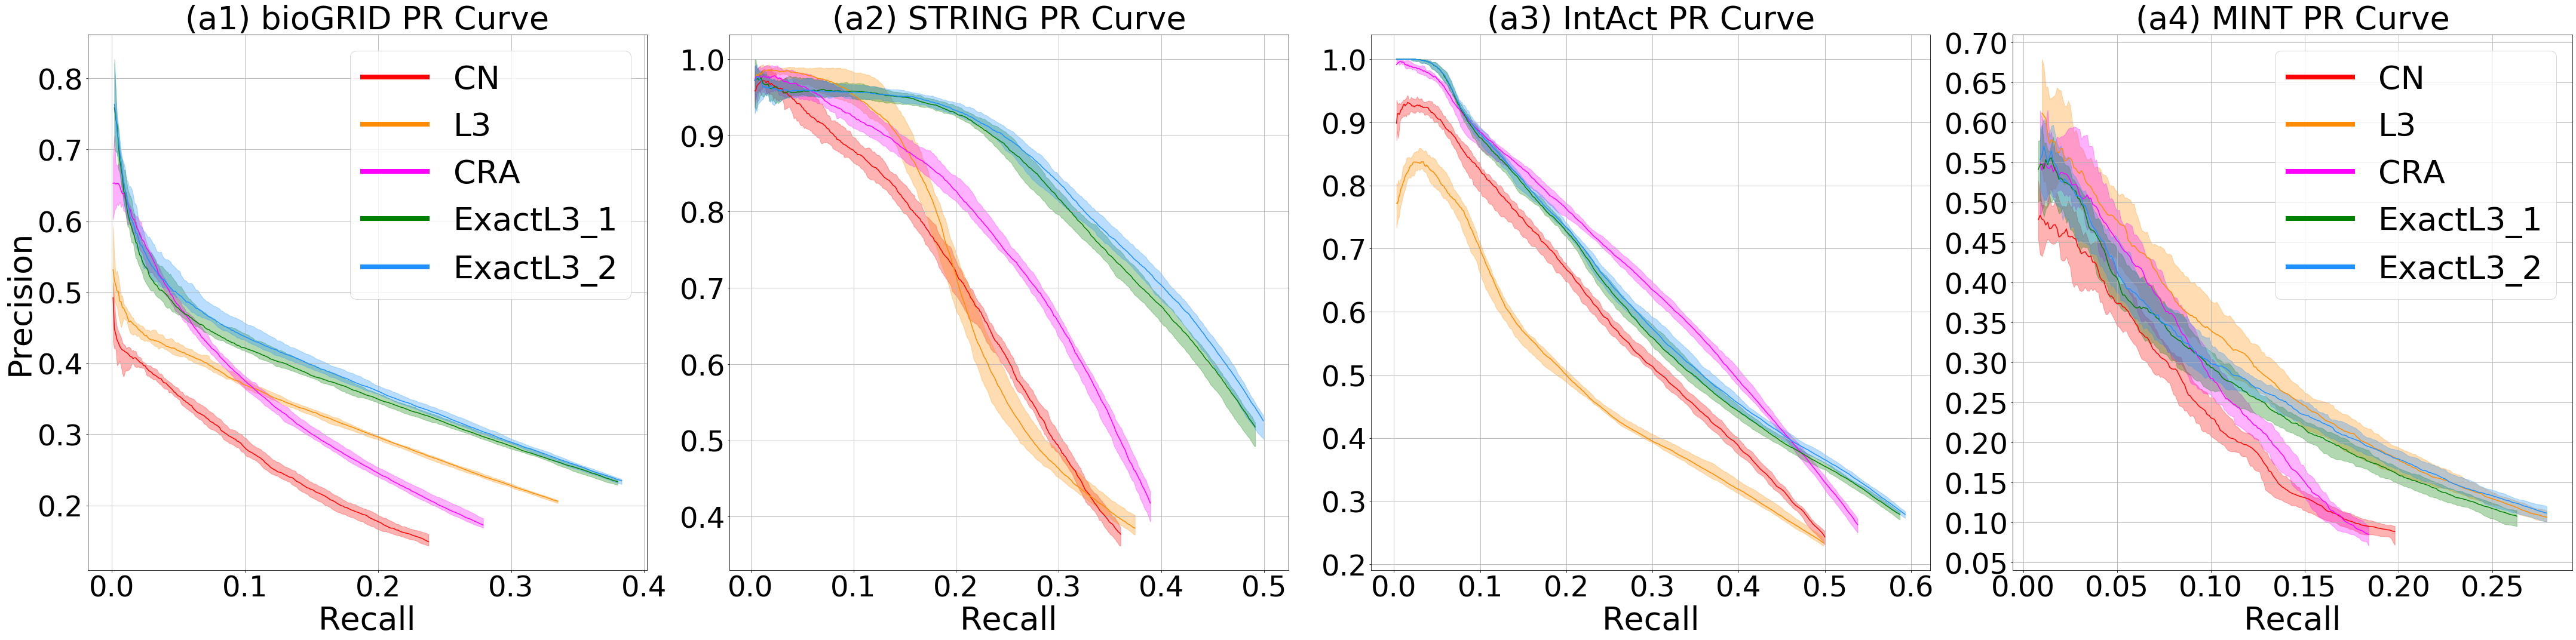

In [14]:
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'CRA_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_']
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']
fNamesTitle = ['(a1) bioGRID PR Curve', '(a2) STRING PR Curve', '(a3) IntAct PR Curve', '(a4) MINT PR Curve']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48)
plt.rc('ytick', labelsize=48)
plt.rc('legend', fontsize=54) 
fig, axes = plt.subplots(1, 4, figsize=(60,15))
xIntervals, yIntervals = [0.1, 0.1, 0.1, 0.05], [0.1, 0.1, 0.1, 0.05]
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
for j in range(len(datasets)):
    dataset = datasets[j]
    fNames = [i+dataset for i in fNamesList]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    tags = ['CN', 'L3', 'CRA', 'ExactL3_1', 'ExactL3_2']
    slideRange = (100, len(precRecMap[fNames[0]+"_0"]["prec"]))
    precsList = [[precRecMap[fName+"_{}".format(i)]["prec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    recsList = [[precRecMap[fName+"_{}".format(i)]["rec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    xInterval, yInterval = xIntervals[j], yIntervals[j]
    axes[j].set_xticks([i*xInterval for i in range(0, int((1+xInterval)/xInterval))])
    axes[j].set_yticks([i*yInterval for i in range(0, int((1+yInterval)/yInterval))])

    for i in range(len(fNames)):
        prec, rec = precsList[i], recsList[i]
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        axes[j].fill_between(baseRec, lowerPrec, upperPrec, facecolor=color[i], color=color[i], alpha=0.3)
        axes[j].plot(baseRec, avgPrec, color=color[i], label=tags[i])
    axes[j].set_xlabel("Recall")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
leg = axes[0].legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
leg = axes[3].legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
axes[0].set_ylabel("Precision")
plt.tight_layout()
plt.savefig('./img/PRCurve.png')
plt.show()

CN top 2000 mean precisions in bioGRID: 0.40885
L3 top 2000 mean precisions in bioGRID: 0.45230000000000004
ExactL3_1 top 2000 mean precisions in bioGRID: 0.55525
ExactL3_2 top 2000 mean precisions in bioGRID: 0.5694
CRA top 2000 mean precisions in bioGRID: 0.5787


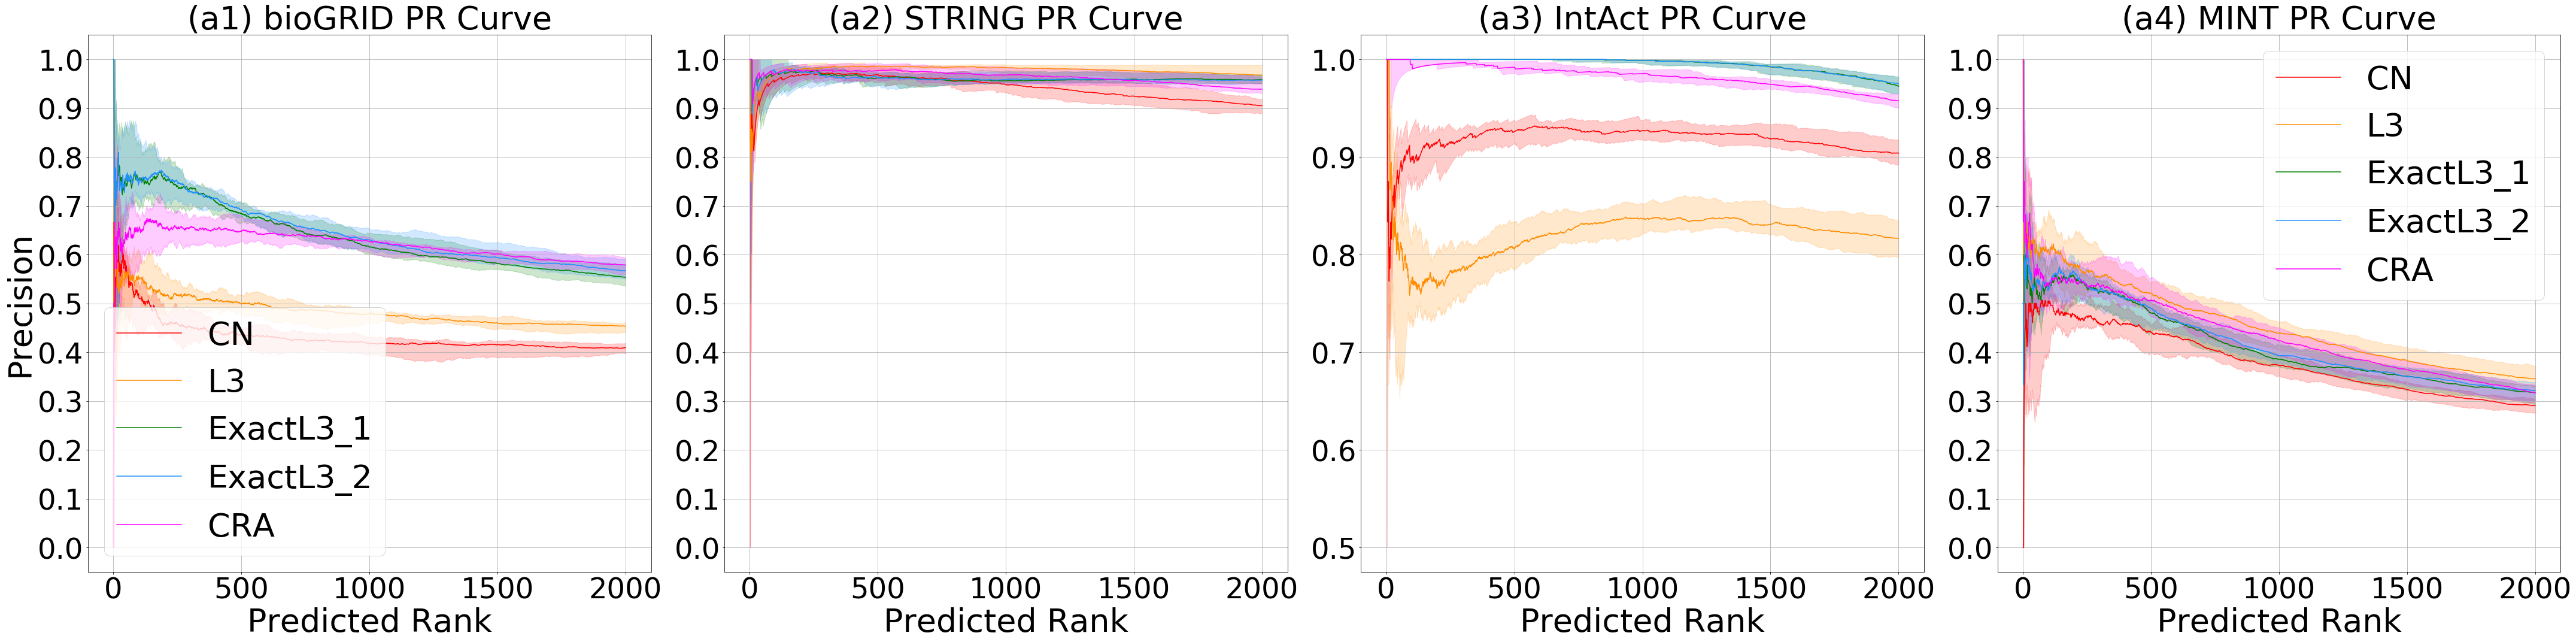

In [43]:
# top 2000
top = 2000

fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_', 'CRA_tenTrial_']
color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
fNamesTitle = ['(a1) bioGRID PR Curve', '(a2) STRING PR Curve', '(a3) IntAct PR Curve', '(a4) MINT PR Curve']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48)
plt.rc('ytick', labelsize=48)
plt.rc('legend', fontsize=54) 
fig, axes = plt.subplots(1, 4, figsize=(60,15))
xIntervals, yIntervals = [500,500,500,500], [0.1, 0.1, 0.1, 0.1]
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
for j in range(len(datasets)):
    dataset = datasets[j]
    fNames = [i+dataset for i in fNamesList]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    tags = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
    slideRange = (0, top)
    precsList = [[precRecMap[fName+"_{}".format(i)]["prec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    recsList = [[precRecMap[fName+"_{}".format(i)]["rec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    xInterval, yInterval = xIntervals[j], yIntervals[j]
    axes[j].set_xticks([i*xInterval for i in range(0, int((top+xInterval)/xInterval))])
    axes[j].set_yticks([i*yInterval for i in range(0, int((1+yInterval)/yInterval))])

    for i in range(len(fNames)):
        prec, rec = precsList[i], recsList[i]
        #alignedPrecs, _ = standardize_plots(prec, rec, 3)
        if dataset == 'bioGRID': 
            print('{} top {} mean precisions in bioGRID: {}'.format(tags[i], top, mean([p[top-1] for p in prec])))
        alignedPrecs = prec
        PPIRanks = [i for i in range(1, top+1)]
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        axes[j].fill_between(PPIRanks, lowerPrec, upperPrec, facecolor=color[i], color=color[i], alpha=0.2)
        axes[j].plot(PPIRanks, avgPrec, color=color[i], label=tags[i])
    axes[j].set_xlabel("Predicted Rank")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
axes[0].legend()
axes[3].legend()
axes[0].set_ylabel("Precision")
plt.tight_layout()
plt.savefig('./img/PRCurve.png')
plt.show()

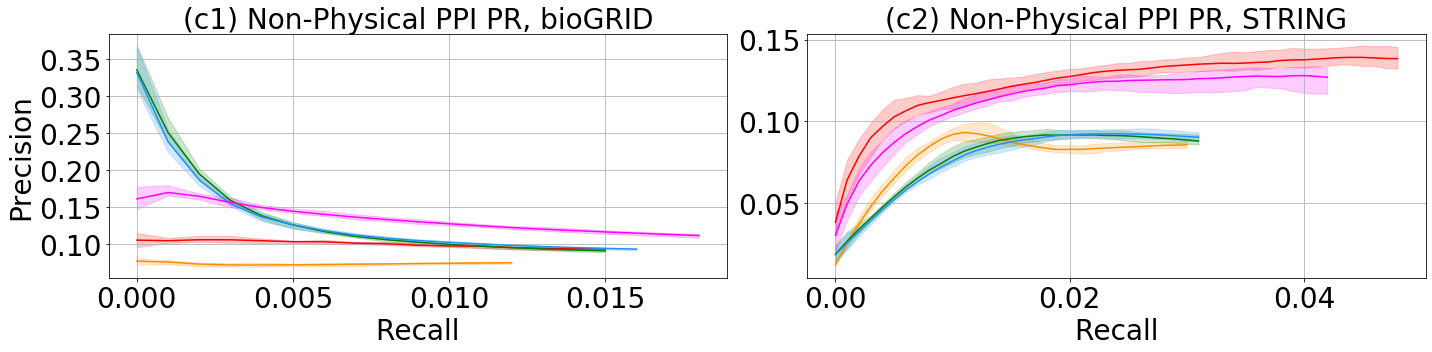

In [15]:
fNamesList = [['commonNeighbor_tenTrial_bioGRID', 'L3uvJoin_tenTrial_bioGRID', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_bioGRID', 'CRA_tenTrial_bioGRID'], ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING']]
color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
fNamesTitle = ['(c1) Non-Physical PPI PR, bioGRID', '(c2) Non-Physical PPI PR, STRING']
plt.rc('axes', titlesize=28)
plt.rc('axes', labelsize=28)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('legend', fontsize=28) 
fig, axes = plt.subplots(1, 2, figsize=(20,5))
xIntervals, yIntervals = [0.005, 0.02], [0.05, 0.05]
for j in range(0, 2):
    fNames = fNamesList[j]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    tags = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
    slideRange = (100, len(precRecMap[fNames[0]+"_GGI_0"]["prec"]))
    precsList = [[precRecMap[fName+"_GGI_{}".format(i)]["prec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    recsList = [[precRecMap[fName+"_GGI_{}".format(i)]["rec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    xInterval, yInterval = xIntervals[j], yIntervals[j]
    axes[j].set_xticks([i*xInterval for i in range(0, int((1+xInterval)/xInterval))])
    axes[j].set_yticks([i*yInterval for i in range(0, int((1+yInterval)/yInterval))])

    for i in range(len(fNames)):
        prec, rec = precsList[i], recsList[i]
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, mean)
        axes[j].fill_between(baseRec, lowerPrec, upperPrec, facecolor=color[i], color=color[i], alpha=0.2)
        axes[j].plot(baseRec, avgPrec, color=color[i], label=tags[i])
    axes[j].set_xlabel("Recall")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
axes[0].set_ylabel("Precision")
#axes[1].legend()
plt.tight_layout()
plt.savefig('./img/GGIPR.png')
plt.show()

# Bio Significance

In [ ]:
# remember to check if PPI exists only in STRING dataset, but not STRING type dataset (STRINB_df only store those with type)

In [16]:
# top all, window 100, sliding 10
fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING']
tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
_, STRING_df = STRING.parse_STRING(root='../')
STRING_PPI = [tr.Helper.br_to_pathStr(list(ppi)) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_PPI += [tr.Helper.br_to_pathStr(list(ppi)[::-1]) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_Score = list(np.asarray(STRING_df['score']))+list(np.asarray(STRING_df['score']))
STRING_scoreMap = dict(zip(STRING_PPI, STRING_Score))

window, slidingFrame = 100, 10
ppiMMScoresList = defaultdict(list)
for fName in fNames: # 4 algorithms
    predPPI = np.asarray([tr.Helper.list_to_pathStrs(PPIs) for PPIs in predPPIs[fName]])
    for ppiArr in predPPI: # 10 trials
        ppiMMScoresList[fName].append([])
        for i in range(0, len(ppiArr)-window, slidingFrame):
            ppiCluster = ppiArr[i:i+window]
            scores = [STRING_scoreMap[ppiStr] if ppiStr in STRING_scoreMap else 0 for ppiStr in ppiCluster]
            if len(scores) > 0: ppiMMScoresList[fName][-1].append(mean(scores))
            else: ppiMMScoresList[fName][-1].append(0)

In [18]:
# top all, window 100, sliding 10
fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING']
tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
_, STRING_df = STRING.parse_STRING(root='../')
STRING_PPI = [tr.Helper.br_to_pathStr(list(ppi)) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_PPI += [tr.Helper.br_to_pathStr(list(ppi)[::-1]) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_Score = list(np.asarray(STRING_df['score']))+list(np.asarray(STRING_df['score']))
STRING_scoreMap = dict(zip(STRING_PPI, STRING_Score))

window, slidingFrame = 100, 10
ppiAvgScoresList = defaultdict(list)
for fName in fNames: # 4 algorithms
    predPPI = np.asarray([tr.Helper.list_to_pathStrs(PPIs) for PPIs in predPPIs[fName]])
    for ppiArr in predPPI: # 10 trials
        ppiAvgScoresList[fName].append([])
        for i in range(1, len(ppiArr), slidingFrame):
            if i == 1: ppiCluster = ppiArr[0:i]
            else: ppiCluster = ppiArr[i-slidingFrame:i]
            scores = [STRING_scoreMap[ppiStr] if ppiStr in STRING_scoreMap else 0 for ppiStr in ppiCluster]
            if len(scores) > 0: 
                if i == 1: ppiAvgScoresList[fName][-1].append(sum(scores))
                else: ppiAvgScoresList[fName][-1].append(ppiAvgScoresList[fName][-1][-1]+sum(scores))
            else: ppiAvgScoresList[fName][-1].append(0)
        ppiAvgScoresList[fName][-1] = list(np.asarray(ppiAvgScoresList[fName][-1])/np.asarray([i for i in range(1, len(ppiArr), slidingFrame)]))

In [36]:
# top all, window 100, sliding 10, STRING
tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'uvSpec_xySpec_xyContrib_uvJoin', 'CRA']
fNames = ['{}_tenTrial_{}'.format(tag, dataset) for tag in tags for dataset in ['STRING', 'bioGRID', 'MINT', 'IntAct_spoke']]

window, slidingFrame = 100, 10
ppiAvgGOScoresDict = defaultdict(list)
for fName in fNames: # 5 algorithms
    for scoreArr in GOScores[fName]: # 10 trials
        ppiAvgGOScoresDict[fName].append([mean(scoreArr[i:i+window]) for i in range(0, len(scoreArr)-window, slidingFrame)])
with open('./resultData/GOSemSimDict.json', 'w') as f:
    f.write(json.dumps(ppiAvgGOScoresDict))

In [37]:
# cumlative GOSEmSim
tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'uvSpec_xySpec_xyContrib_uvJoin', 'CRA']
fNames = ['{}_tenTrial_{}'.format(tag, dataset) for tag in tags for dataset in ['STRING', 'bioGRID', 'MINT', 'IntAct_spoke']]

slidingFrame = 10
ppiAvgGOScoresDict = defaultdict(list)
for fName in fNames: # 5 algorithms
    for scoreArr in GOScores[fName]: # 10 trials
        sumList = []
        for i in range(1, len(scoreArr), slidingFrame):
            if len(sumList) == 0: sumList.append(sum(scoreArr[0:i]))
            else: sumList.append(sumList[-1]+sum(scoreArr[i-slidingFrame:i]))
        ppiAvgGOScoresDict[fName].append(list(np.asarray(sumList)/np.asarray([i for i in range(1, len(scoreArr), slidingFrame)])))
with open('./resultData/avg_GOSemSimDict.json', 'w') as f:
    f.write(json.dumps(ppiAvgGOScoresDict))

In [12]:
ppiMMGOScoresDict = {}
with open('./resultData/GOSemSimDict.json', 'r') as f:
    ppiMMGOScoresDict = json.loads(f.read())
    
ppiAvgGOScoresDict = {}
with open('./resultData/avg_GOSemSimDict.json', 'r') as f:
    ppiAvgGOScoresDict = json.loads(f.read())

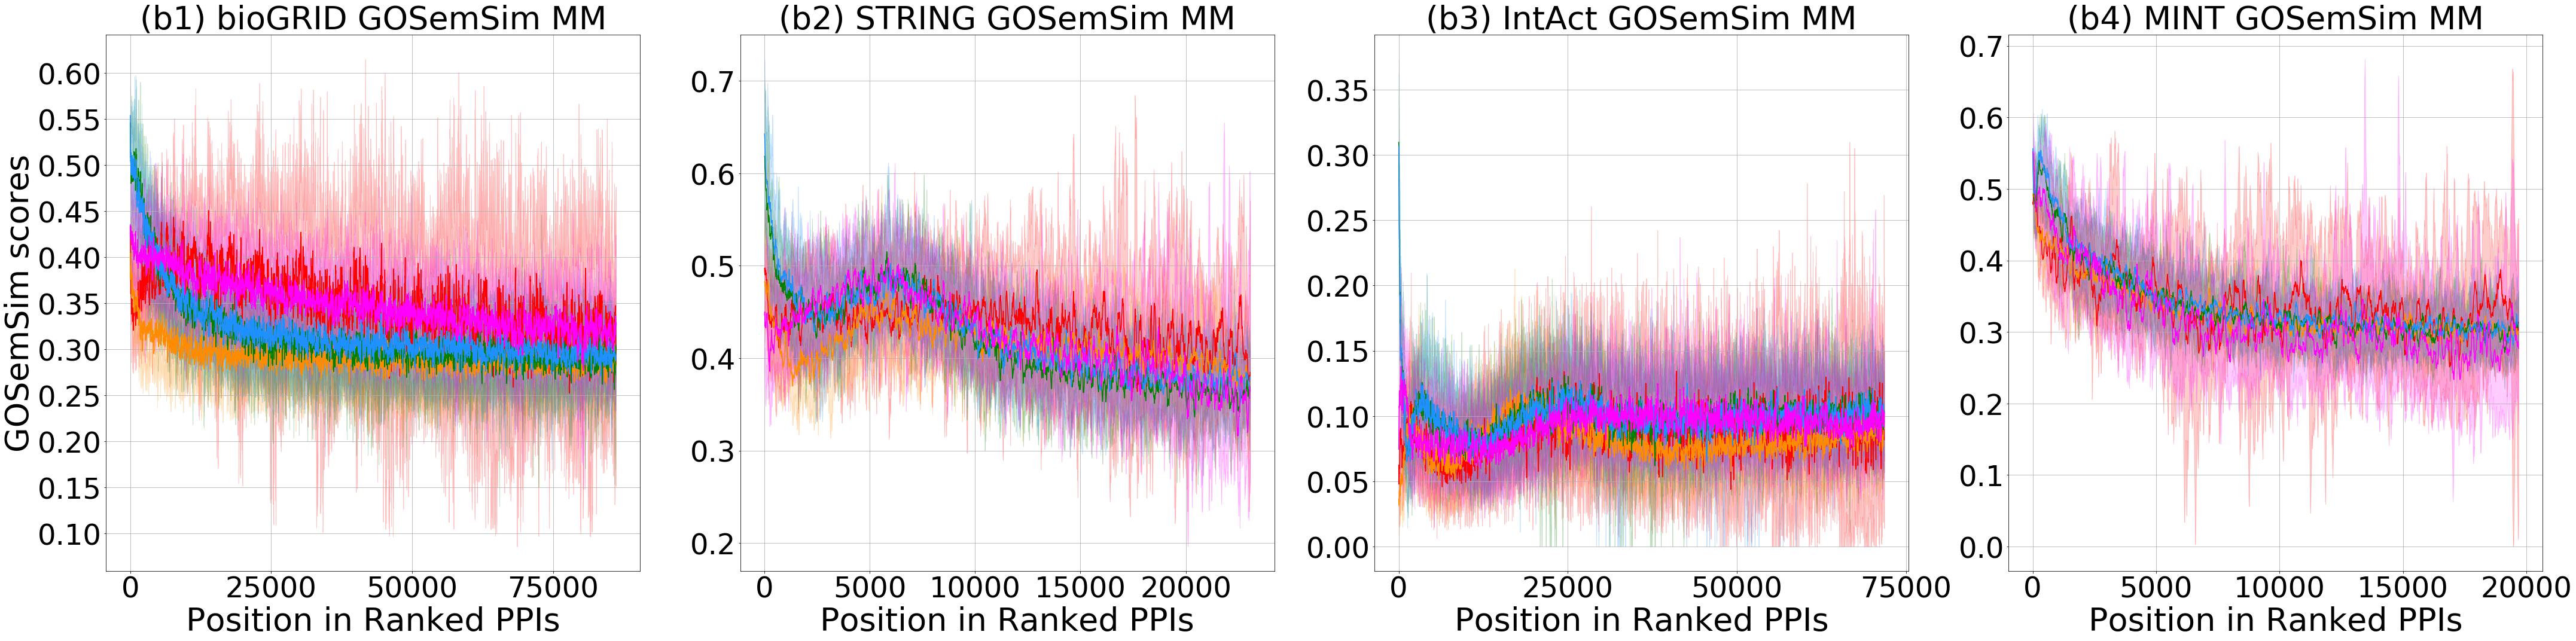

In [50]:
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
tags = ['CN', 'L3', 'ExactL3: xyContrib_dualCN', 'ExactL3: uvSpec_xySpec_xyContrib']


fig, axes = plt.subplots(1, 4, figsize=(60,15))

tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'uvSpec_xySpec_xyContrib_uvJoin', 'CRA']
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
labels = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
titles = ['(b1) bioGRID GOSemSim MM', '(b2) STRING GOSemSim MM', '(b3) IntAct GOSemSim MM', '(b4) MINT GOSemSim MM']
xIntervals, yIntervals = [25000, 5000, 25000, 5000], [0.05, 0.1, 0.05, 0.1]
for k in range(len(datasets)):
    dataset = datasets[k]
    fNames = ['{}_tenTrial_{}'.format(tag, dataset) for tag in tags]
    xInterval, yInterval = xIntervals[k], yIntervals[k]
    xList = [(i+1)*10 for i in range(len(ppiMMGOScoresDict[fNames[0]][0]))]
    xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
    axes[k].set_xticks(xTicks)
    axes[k].set_yticks(yTicks)
    for i in range(len(fNames)):
        upperScore, lowerScore, avgScore = get_plots_outline(ppiMMGOScoresDict[fNames[i]], max), get_plots_outline(ppiMMGOScoresDict[fNames[i]], min), get_plots_outline(ppiMMGOScoresDict[fNames[i]], mean)
        axes[k].fill_between(xList, lowerScore, upperScore, facecolor=color[i], color=color[i], alpha=0.2)
        axes[k].plot(xList, avgScore, color=color[i], label=labels[i])
    axes[k].grid()
    axes[k].set_xlabel('Position in Ranked PPIs')
    axes[k].set_title(titles[k])
axes[0].set_ylabel('GOSemSim scores')
#axes[3].legend()
#axes[1].set_title('(b) STRING: Moving Average of GOSemSim')
#plt.legend()

plt.tight_layout()
plt.savefig('./img/GOSemSim.png')
plt.show()

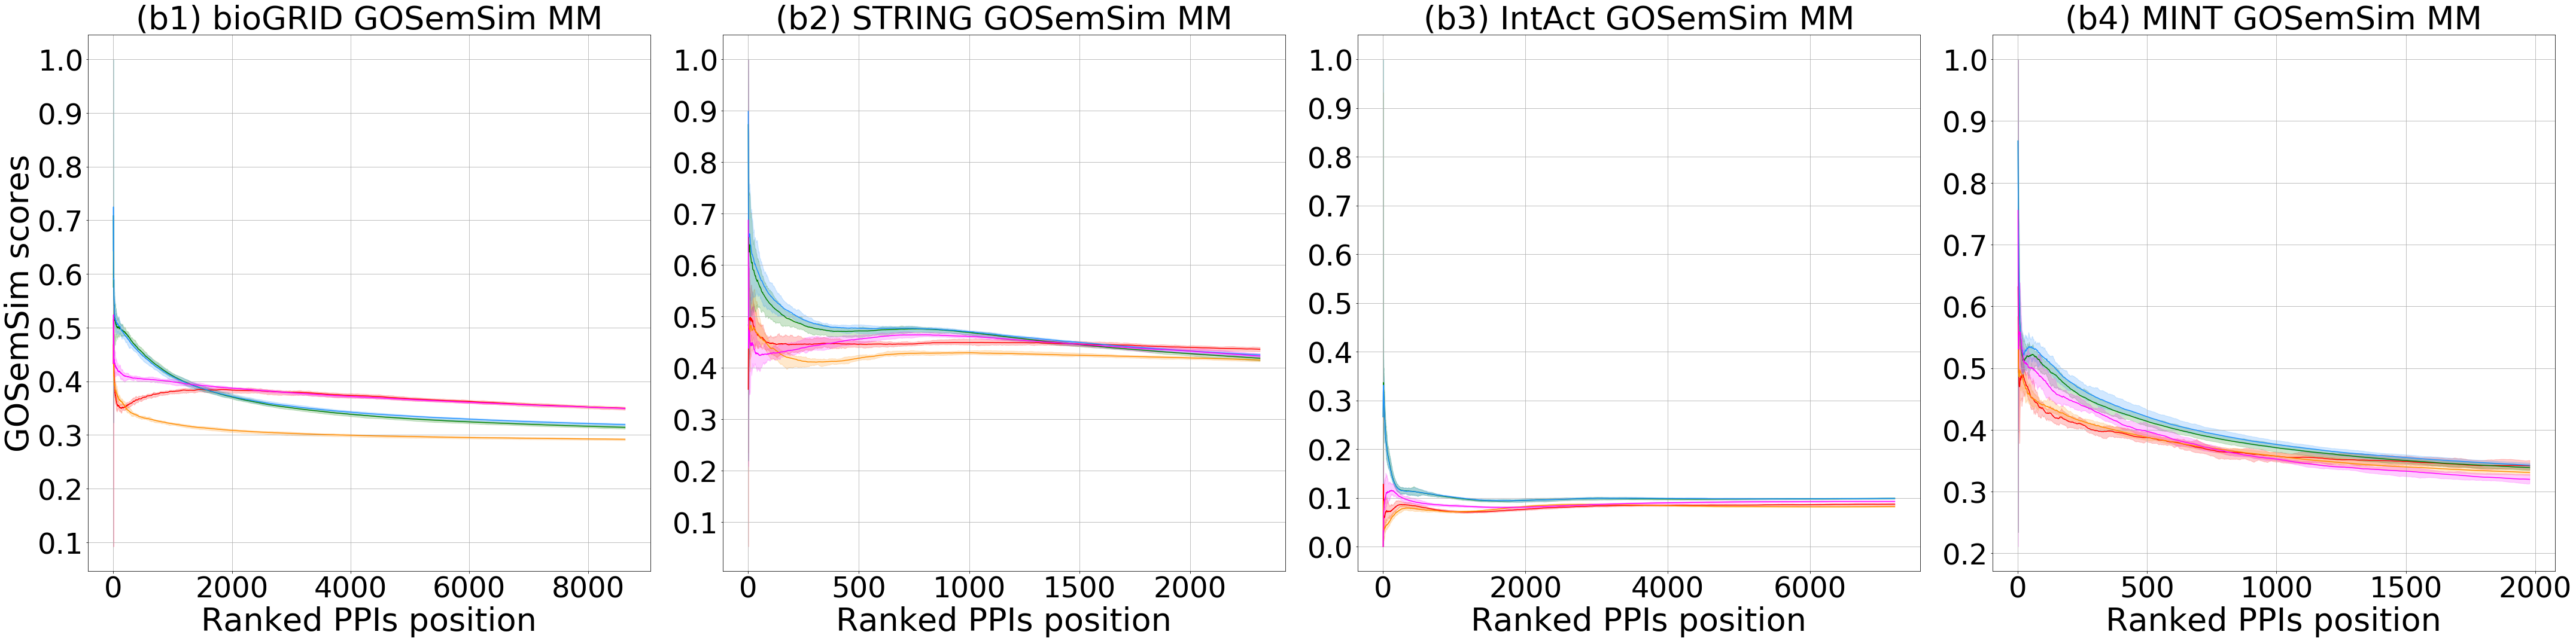

In [46]:
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
tags = ['CN', 'L3', 'ExactL3: xyContrib_dualCN', 'ExactL3: uvSpec_xySpec_xyContrib']


fig, axes = plt.subplots(1, 4, figsize=(60,15))

tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'uvSpec_xySpec_xyContrib_uvJoin', 'CRA']
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
labels = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
titles = ['(b1) bioGRID GOSemSim MM', '(b2) STRING GOSemSim MM', '(b3) IntAct GOSemSim MM', '(b4) MINT GOSemSim MM']
xIntervals, yIntervals = [2000, 500, 2000, 500], [0.1, 0.1, 0.1, 0.1]
for k in range(len(datasets)):
    dataset = datasets[k]
    fNames = ['{}_tenTrial_{}'.format(tag, dataset) for tag in tags]
    xInterval, yInterval = xIntervals[k], yIntervals[k]
    xList = [i+1 for i in range(len(ppiAvgGOScoresDict[fNames[0]][0]))]
    xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
    axes[k].set_xticks(xTicks)
    axes[k].set_yticks(yTicks)
    for i in range(len(fNames)):
        upperScore, lowerScore, avgScore = get_plots_outline(ppiAvgGOScoresDict[fNames[i]], max), get_plots_outline(ppiAvgGOScoresDict[fNames[i]], min), get_plots_outline(ppiAvgGOScoresDict[fNames[i]], mean)
        axes[k].fill_between(xList, lowerScore, upperScore, facecolor=color[i], color=color[i], alpha=0.2)
        axes[k].plot(xList, avgScore, color=color[i], label=labels[i])
    axes[k].grid()
    axes[k].set_xlabel('Ranked PPIs position')
    axes[k].set_title(titles[k])
axes[0].set_ylabel('GOSemSim scores')
#axes[3].legend()
#axes[1].set_title('(b) STRING: Moving Average of GOSemSim')
#plt.legend()

plt.tight_layout()
plt.savefig('./img/GOSemSim.png')
plt.show()

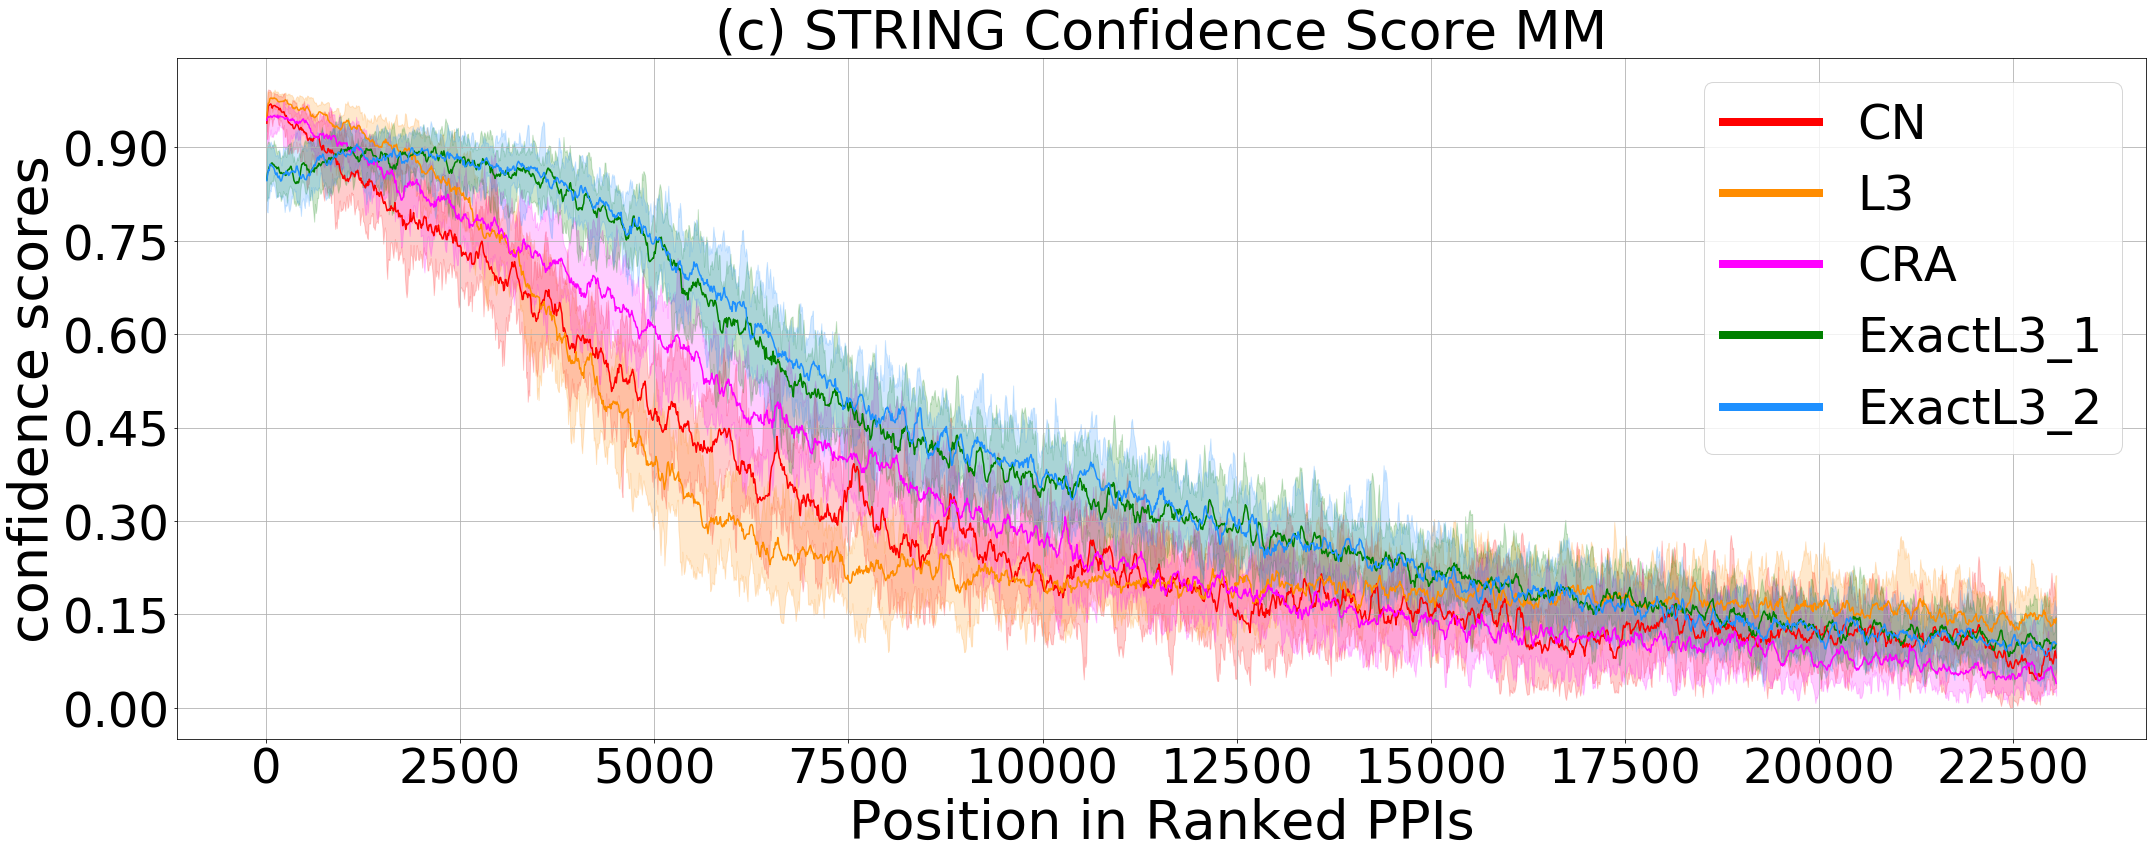

In [21]:
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig = plt.figure(figsize=(30,12))
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']
tags = ['CN', 'L3', 'CRA', 'ExactL3_1', 'ExactL3_2']

fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING']
xInterval, yInterval = 2500, 0.15
xList = [(i+1)*10 for i in range(len(ppiMMScoresList[fNames[0]][0]))]
xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
plt.xticks(xTicks)
plt.yticks(yTicks)
for i in range(len(fNames)):
    upperScore, lowerScore, avgScore = get_plots_outline(ppiMMScoresList[fNames[i]], max), get_plots_outline(ppiMMScoresList[fNames[i]], min), get_plots_outline(ppiMMScoresList[fNames[i]], mean)
    plt.fill_between(xList, lowerScore, upperScore, facecolor=color[i], color=color[i], alpha=0.2)
    plt.plot(xList, avgScore, color=color[i], label=tags[i])
ax = plt.gca()
ax.set_xlabel('Position in Ranked PPIs')
ax.set_ylabel('confidence scores')
ax.set_title('(c) STRING Confidence Score MM')
ax.grid()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.tight_layout()
plt.savefig('./img/confScore.png')
plt.show()

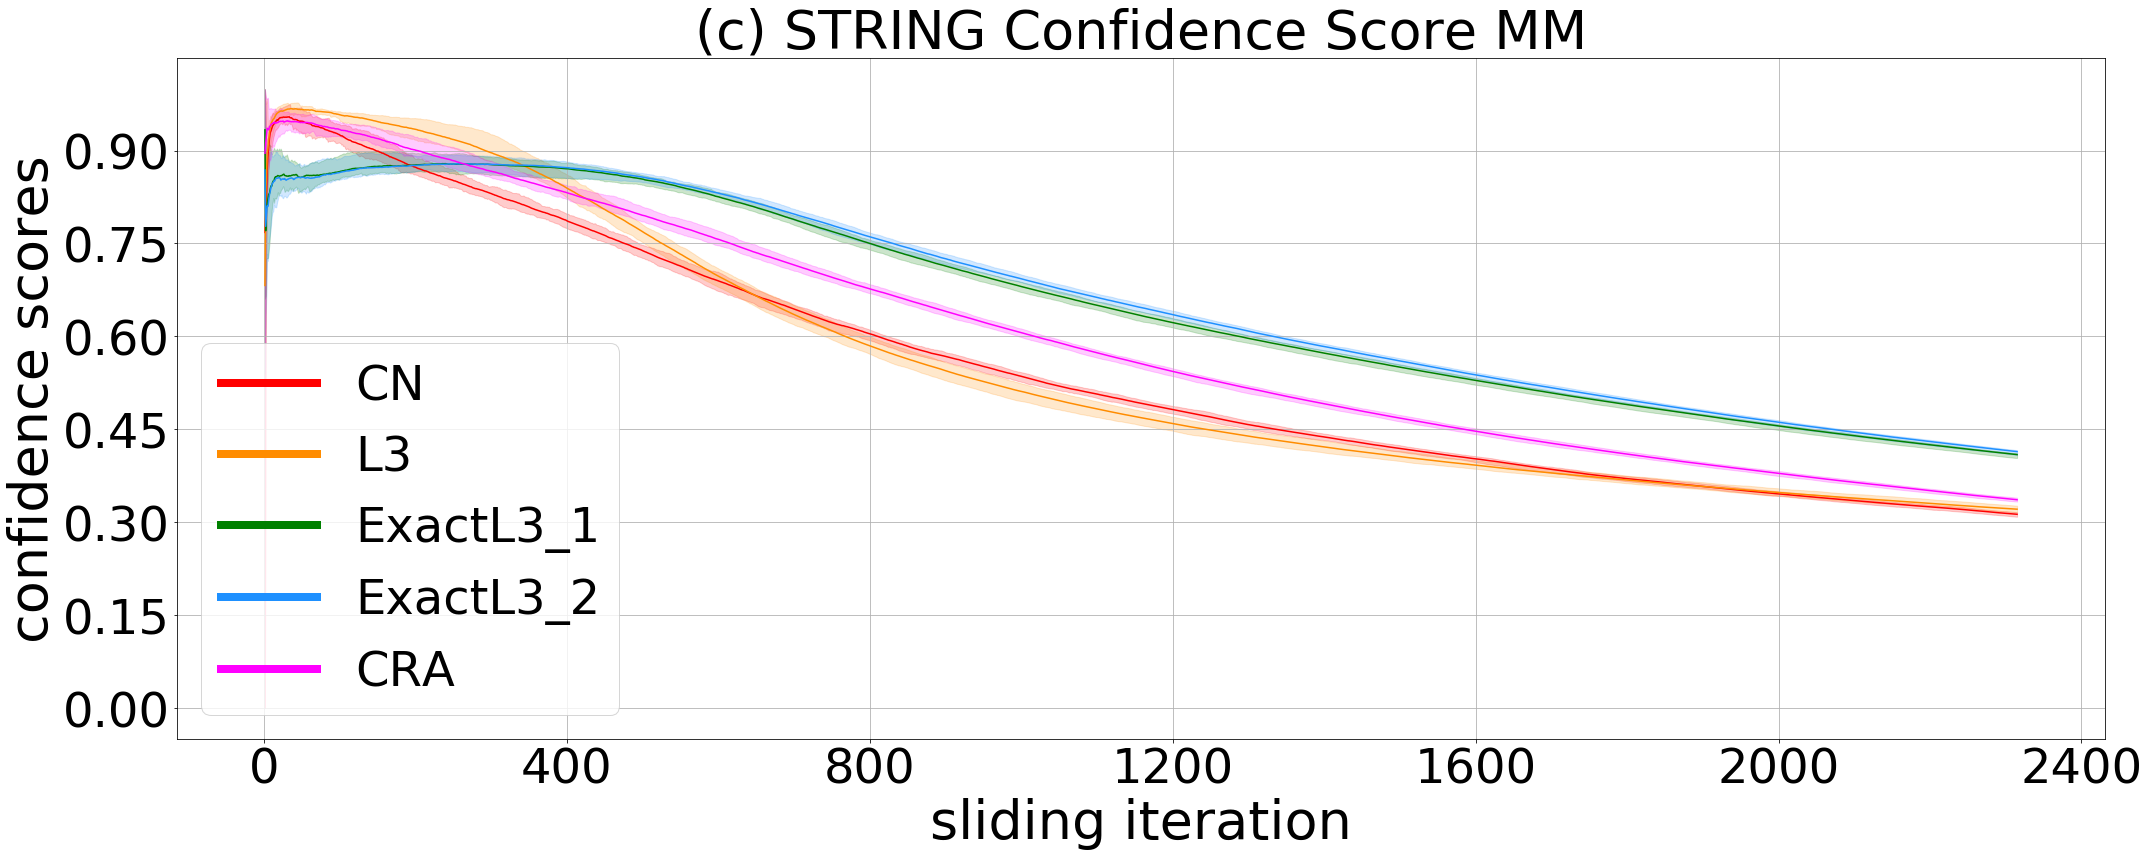

In [19]:
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig = plt.figure(figsize=(30,12))
color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
tags = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']

fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING']
xInterval, yInterval = 400, 0.15
xList = [i+1 for i in range(len(ppiAvgScoresList[fNames[0]][0]))]
xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
plt.xticks(xTicks)
plt.yticks(yTicks)
for i in range(len(fNames)):
    upperScore, lowerScore, avgScore = get_plots_outline(ppiAvgScoresList[fNames[i]], max), get_plots_outline(ppiAvgScoresList[fNames[i]], min), get_plots_outline(ppiAvgScoresList[fNames[i]], mean)
    plt.fill_between(xList, lowerScore, upperScore, facecolor=color[i], color=color[i], alpha=0.2)
    plt.plot(xList, avgScore, color=color[i], label=tags[i])
ax = plt.gca()
ax.set_xlabel('sliding iteration')
ax.set_ylabel('confidence scores')
ax.set_title('(c) STRING Confidence Score MM')
ax.grid()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.tight_layout()
plt.savefig('./img/confScore.png')
plt.show()

# Essential Gene Growth Rate

In [24]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_', 'CRA_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING', 'bioGRID', 'MINT', 'IntAct_spoke']]
hitNum = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    hitList = []
    for i in range(0, 10):
        hitList.append([])
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            hitList[-1].append(len(nodeList&essGenes))
    hitNum[fName] = hitList.copy()
with open('./resultData/hitNumDict.json', 'w') as f:
    f.write(json.dumps(hitNum))

In [25]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_', 'CRA_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING', 'bioGRID', 'MINT', 'IntAct', 'IntAct_spoke']]
essDegDict = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    essDegs = []
    if 'bioGRID' in fName: samplePPIr = bg_samplePPIr.copy()
    elif 'STRING' in fName: samplePPIr = STRING_samplePPIr.copy()
    elif 'MINT' in fName: samplePPIr = MINT_samplePPIr.copy()
    elif 'IntAct' in fName and 'spoke' in fName: samplePPIr = IntAct_spoke_samplePPIr.copy()
    for i in range(0, 10):
        essDegs.append([])
        essNodes = set()
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            newEss = (nodeList&essGenes)-essNodes
            essNodes.update(newEss)
            essDegs[-1].append([len(samplePPIr[i][node]) for node in newEss])
    essDegDict[fName] = essDegs.copy()
with open('./resultData/essDegDict.json', 'w') as f:
    f.write(json.dumps(essDegDict))

In [13]:
hitNum = {}
with open('./resultData/hitNumDict.json', 'r') as f:
    hitNum = json.loads(f.read())
essDegDict = {}
with open('./resultData/essDegDict.json', 'r') as f:
    essDegDict = json.loads(f.read())

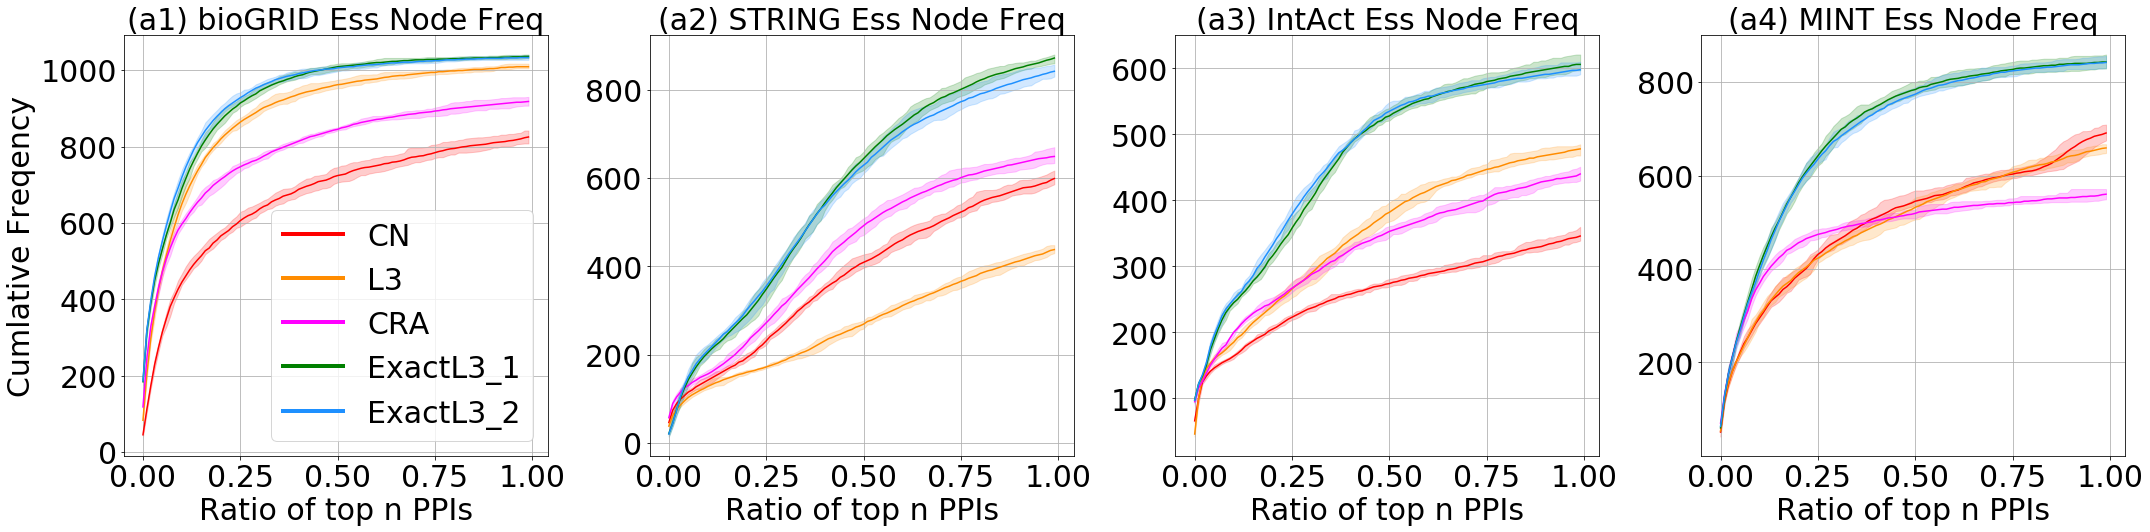

In [24]:
## use essGenes list
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'CRA_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_']
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']
fNamesTitle = ['(a1) bioGRID Ess Node Freq', '(a2) STRING Ess Node Freq', '(a3) IntAct Ess Node Freq', '(a4) MINT Ess Node Freq']
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
fig, axes = plt.subplots(1, 4, figsize=(30,7.5))
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
for j in range(len(datasets)):
    fNames = [i+datasets[j] for i in fNamesList]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    tags = ['CN', 'L3', 'CRA', 'ExactL3_1', 'ExactL3_2']

    for i in range(len(fNames)):
        hitList = hitNum[fNames[i]]
        xList = [[(k+1)/len(l) for k in range(0, len(l))] for l in hitList]
        alignedHit, baseX = standardize_plots(hitList, xList, 2)
        upperHit, lowerHit, avgHit = get_plots_outline(alignedHit, max), get_plots_outline(alignedHit, min), get_plots_outline(alignedHit, mean)
        axes[j].fill_between(baseX, lowerHit, upperHit, facecolor=color[i], color=color[i], alpha=0.2)
        axes[j].plot(baseX, avgHit, color=color[i], label=tags[i])
        axes[j].set_xticks([i/100 for i in range(0,110,25)])
    axes[j].set_xlabel("Ratio of top n PPIs")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
leg = axes[0].legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
#axes[3].legend()
axes[0].set_ylabel("Cumlative Freqency")
plt.tight_layout()
plt.savefig('./img/essGeneFreq.png')
plt.show()

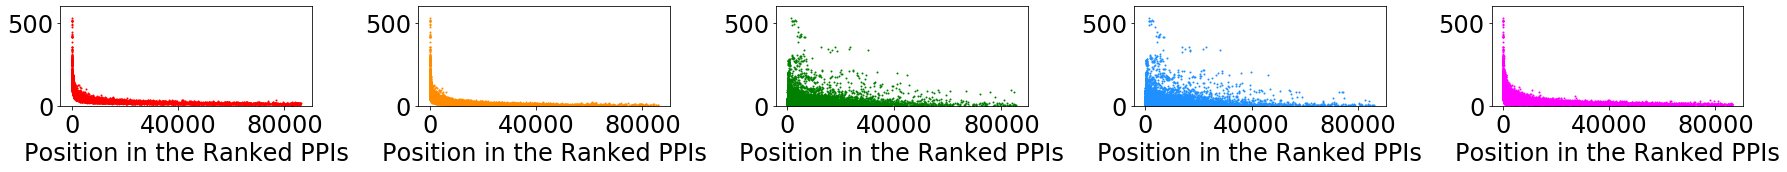

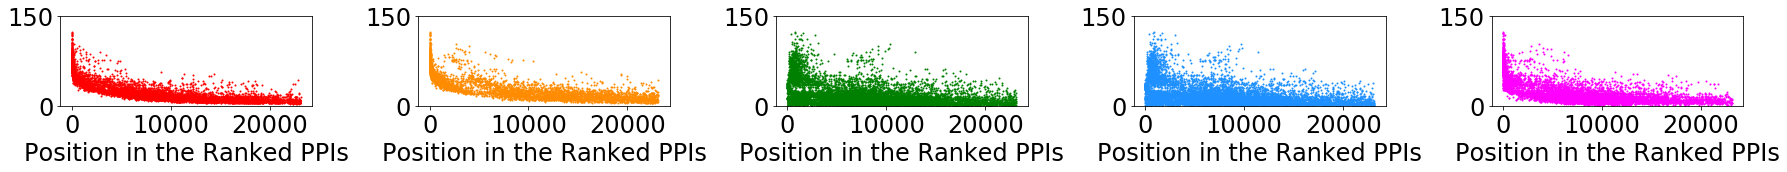

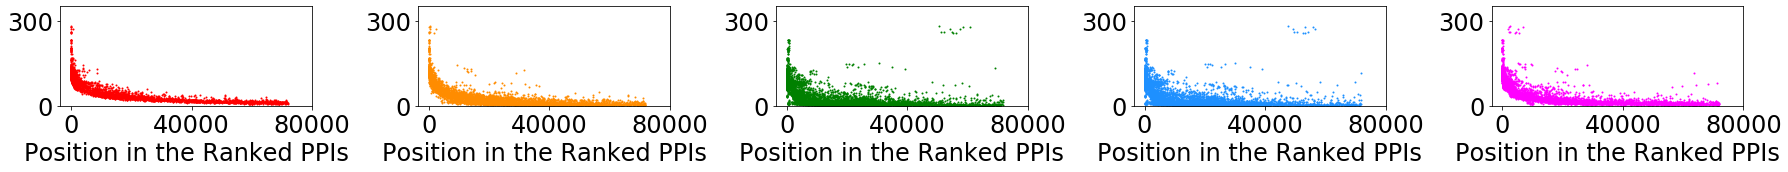

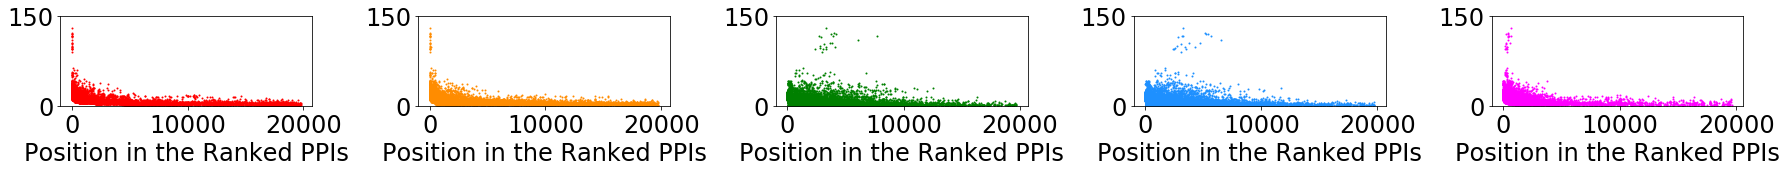

In [53]:
#plt.rc('font', size=10)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rc('legend', fontsize=20) 
    
# removed one outlier, the one with 1200 degree
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
xIntervals = [range(0,100000,40000), range(0,30000, 10000), range(0,100000,40000), range(0,30000, 10000)]
yIntervals = [range(0,800,500), range(0,200,150), range(0,400,300), range(0,200,150)]
yLimits = [[0, 600], [0,150], [0,350], [0,150]]
for n in range(len(datasets)):
    dataset = datasets[n]
    tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_', 'CRA_tenTrial_']
    fNames = [i+dataset for i in tags]
    color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
    tags = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
    curEssDegFlat, xList = [], []
    for i in range(len(fNames)):
        tmpxList, tmpDegFlat = [], []
        for j in range(10):
            curEssDeg = essDegDict[fNames[i]][j]
            tmpxList += [a for a in range(len(curEssDeg)) for k in curEssDeg[a]]
            tmpDegFlat += [k for a in curEssDeg for k in a]
        xList.append(tmpxList)
        curEssDegFlat.append(tmpDegFlat)

    fig, axes = plt.subplots(1, 5, figsize=(25,2.5))
    for i in range(len(curEssDegFlat)):
        axes[i].set_xlabel('Position in the Ranked PPIs')
        axes[i].scatter(xList[i], curEssDegFlat[i], color=color[i], s=1, label=tags[i])
        axes[i].set_xticks(xIntervals[n])
        axes[i].set_yticks(yIntervals[n])
        axes[i].set_ylim(yLimits[n])
        #axes[i].legend()
    #axes[0].set_ylabel("Essential Node's Degree")
    #plt.suptitle('(c) bioGRID, Degree of Essential Node from Ranked PPIs', fontsize=22)
    plt.tight_layout()
    plt.savefig('./img/EssNode_{}.png'.format(dataset))
    plt.show()

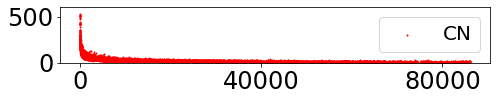

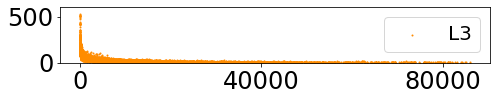

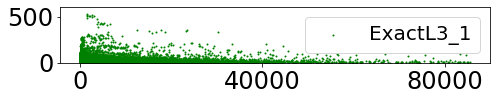

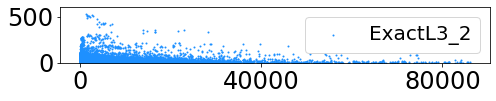

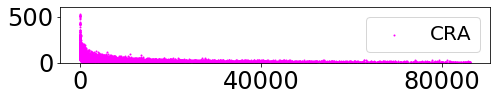

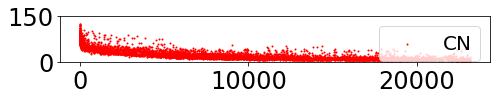

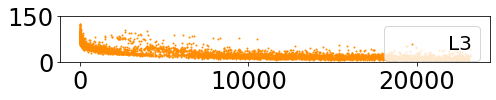

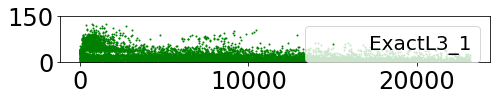

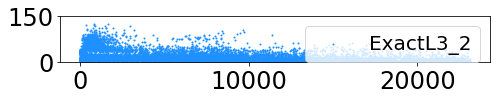

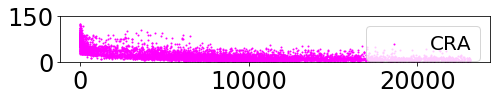

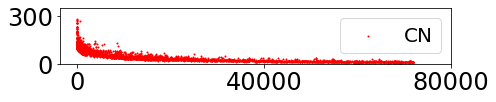

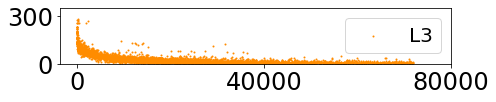

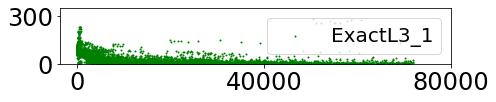

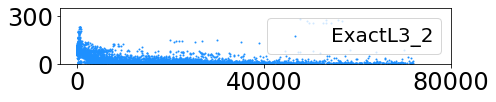

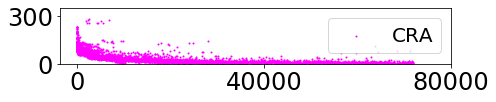

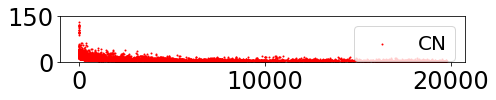

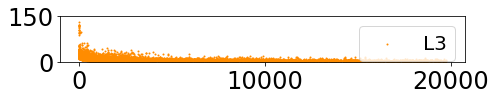

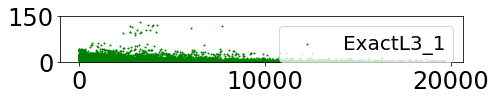

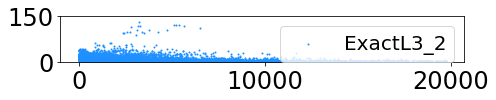

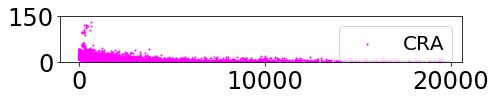

In [21]:
#plt.rc('font', size=10)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)
plt.rc('legend', fontsize=20) 
    
# removed one outlier, the one with 1200 degree
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
xIntervals = [range(0,100000,40000), range(0,30000, 10000), range(0,100000,40000), range(0,30000, 10000)]
yIntervals = [range(0,800,500), range(0,200,150), range(0,400,300), range(0,200,150)]
yLimits = [[0, 600], [0,150], [0,350], [0,150]]
titles = ["(b1) Ess Node's Degree, bioGRID", "(b2) Ess Node's Degree, STRING", "(b3) Ess Node's Degree, IntAct", "(b4) Ess Node's Degree, MINT"]
for n in range(len(datasets)):
    dataset = datasets[n]
    tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_', 'CRA_tenTrial_']
    fNames = [i+dataset for i in tags]
    color = ['red', 'darkorange', 'green', 'dodgerblue', 'fuchsia', 'darkorchid', 'grey']
    tags = ['CN', 'L3', 'ExactL3_1', 'ExactL3_2', 'CRA']
    curEssDegFlat, xList = [], []
    for i in range(len(fNames)):
        tmpxList, tmpDegFlat = [], []
        for j in range(10):
            curEssDeg = essDegDict[fNames[i]][j]
            tmpxList += [a for a in range(len(curEssDeg)) for k in curEssDeg[a]]
            tmpDegFlat += [k for a in curEssDeg for k in a]
        xList.append(tmpxList)
        curEssDegFlat.append(tmpDegFlat)

    for i in range(len(curEssDegFlat)):
        fig = plt.figure(figsize=(7,1.5))
        plt.scatter(xList[i], curEssDegFlat[i], color=color[i], s=1, label=tags[i])
        ax = fig.gca()
        ax.set_xticks(xIntervals[n])
        ax.set_yticks(yIntervals[n])
        ax.set_ylim(yLimits[n])
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig('./img/EssNode_{}_{}.png'.format(dataset,tags[i]))